## Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## 1. Изучение данных

Начинаем с импорта библиотек

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math as mt
from scipy import stats as st

##### Таблица users (информация о пользователях):

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

In [ ]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')
users.info()
#users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


<b>Вывод:</b>

Датасет выглядит ровно, за исключением столбца churn_date с малым количеством значений. Судя по исходным условиям, пропущенное значение означает действие тарифа на момент выгрузки данных. Поэтому данная аномалия не требует заполнения пропусков.

Что касается несоответствия типов данных, то напрашивается конверсия столбцов churn_date и reg_date в тип datetime.

##### Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [ ]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


<b>Вывод:</b>

Датасет с одинаковым числом значений по столбцам - явных пропусков не обнаружено.

Согласно исходным условиям, <i>«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.</i>
Это значит, что столбец duration нужно будет привести к целочисленному значению с округлением в большую сторону.
В свою очередь, столбцу call_date нужно будет присвоить тип datetime.

##### Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [ ]:
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


<b>Вывод:</b>

Датасет с одинаковым числом значений по столбцам - явных пропусков не обнаружено.

Cтолбец message_date переведем в тип данных datetime.

##### Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [ ]:
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


<b>Вывод:</b>

Датасет с одинаковым числом значений по столбцам - явных пропусков не обнаружено.

Согласно исходным условиям: <i> для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.</i>
Это значит, что столбец mb_used нужно будет привести к целочисленному значению с округлением в большую сторону.
В свою очередь, столбцу session_date нужно будет присвоить тип datetime.

##### Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [ ]:
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


<b>Вывод:</b>

Пропущенных данных в этом компактном датасете не выявлено. Замена типов данных не требуется.

Обратимся к описанию тарифов "Смарт" и "Ультра" из исходных условий: 

<b>Тариф «Смарт»</b>
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

     Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

<b>Тариф «Ультра»</b>
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

     Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

## 2. Подготовка данных

### 2.1 Приведение данных к нужным типам

По результатам первичного изучения данных, изменим тип данных на временной <i>datetime</i> для следующих столбцов:

* в <i>users</i> столбец даты регистрации reg_date
* в <i>calls</i> столбец даты звонка call_date
* в <i>messages</i> столбец даты сообщения message_date
* в <i>internet</i> столбец даты сессии session_date

In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Также согласно базовым условиям тарифов округлим в большую сторону и изменим тип данных на целочисленный <i>integer</i> для следующих столбцов:

* в <i>calls</i> столбец duration (до целых минут)
* в <i>internet</i> столбец mb_used (до целых мегабайт)

In [ ]:
calls['duration'] = calls['duration'].apply(mt.ceil)
calls['duration'].astype(int)

internet['mb_used'] = internet['mb_used'].apply(mt.ceil)
internet['mb_used'].astype(int)

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       0
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int64

Проверим успешную замену типов данных, где это было необходимо.

In [ ]:
calls.dtypes

id                   object
call_date    datetime64[ns]
duration              int64
user_id               int64
dtype: object

In [ ]:
internet.dtypes

Unnamed: 0               int64
id                      object
mb_used                  int64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [ ]:
users.dtypes

user_id                int64
age                    int64
churn_date            object
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

In [ ]:
messages.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

### 2.2 Нахождение и исправление ошибок в данных

В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

#### 2.2.1 Информация о пользователях

In [ ]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [ ]:
# Число дубликатов в датасете users
users.duplicated().sum()

0

In [ ]:
# Число пропущенных значений в датасете users
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Согласно исходным данным, если значение churn_date пропущено, то тариф ещё действовал на момент выгрузки данных. С остальными данными все в порядке.

In [ ]:
# Проверка на выброс самой ранней даты регистрации пользователя
users['reg_date'].unique().min()

numpy.datetime64('2018-01-01T00:00:00.000000000')

In [ ]:
# Проверка на выброс самой поздней даты регистрации пользователя
users['reg_date'].unique().max()

numpy.datetime64('2018-12-31T00:00:00.000000000')

In [ ]:
# Проверка известных дат отключения тарифа
users['churn_date'].sort_values().unique()

array(['2018-08-17', '2018-08-31', '2018-09-02', '2018-09-26',
       '2018-09-27', '2018-10-03', '2018-10-04', '2018-10-05',
       '2018-10-14', '2018-10-25', '2018-10-27', '2018-10-28',
       '2018-11-07', '2018-11-13', '2018-11-16', '2018-11-21',
       '2018-11-22', '2018-11-26', '2018-11-27', '2018-11-30',
       '2018-12-03', '2018-12-09', '2018-12-11', '2018-12-14',
       '2018-12-16', '2018-12-18', '2018-12-20', '2018-12-21',
       '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26',
       '2018-12-30', nan], dtype=object)

In [ ]:
# Самый популярный тариф
users['tariff'].max()

'ultra'

In [ ]:
# Количество городов в выборке
len(users['city'].sort_values().unique())

76

<b>Выводы по базе пользователей <i>users</i>:</b>
* В выборке 500 пользователей в возрасте от 18 до 75 лет: средний возраст 46-47 лет.
* Подключение к тарифу с 1 января 2018 года по 31 декабря 2018 года
* Отключение тарифа с 17 августа 2018 года по 30 декабря 2018 года
* Тариф "Ультра" является более частотным
* Данные охватывают 76 городов

#### 2.2.2 Информация о звонках

In [ ]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,7.158198,1253.940619
std,5.959173,144.722751
min,0.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


In [ ]:
# Число дубликатов в данных по звонкам
calls.duplicated().sum()

0

In [ ]:
# Число пропущенных значений в данных по звонкам
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [ ]:
# Сортировка по длительности звонков
calls.groupby('duration')['duration'].count().head()

duration
0    39613
1     8402
2     9194
3    10362
4    10918
Name: duration, dtype: int64

Обнаружено существенное количество звонков с нулевой длительностью. Однако согласно исходным условиям не будем считать это ошибкой: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

<b>Выводы по базе звонков <i>calls</i>:</b>
* В выборке 202607 звонков со средней длительностью 7 минут и максимальной длительностью 38 минут.
* Около 20% зарегистрированных звонков - пропущенные

#### 2.2.3 Информация о сообщениях

In [ ]:
messages['user_id'].describe()

count    123036.000000
mean       1256.989410
std         143.523967
min        1000.000000
25%        1134.000000
50%        1271.000000
75%        1381.000000
max        1499.000000
Name: user_id, dtype: float64

In [ ]:
# Поиск дубликатов в базе сообщений
messages.duplicated().sum()

0

In [ ]:
# Поиск пропущенных значений в базе сообщещний
messages.isna().sum(0)

id              0
message_date    0
user_id         0
dtype: int64

In [ ]:
# Анализ самой ранней даты сообщения
messages['message_date'].sort_values().unique().min()

numpy.datetime64('2018-01-02T00:00:00.000000000')

In [ ]:
# Анализ последней даты сообщения
messages['message_date'].sort_values().unique().max()

numpy.datetime64('2018-12-31T00:00:00.000000000')

<b>Выводы по базе сообщений <i>messages</i>:</b>
* В выборке 123036 сообщений, зарегистрированных со 2 января 2018 года по 31 декабря 2018 года.
* Явных аномалий в выборке не замечено

#### 2.2.4 Информация об интернет-сессиях

In [ ]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.622098,1252.099842
std,43127.054745,278.387019,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,139.000000,1130.000000
50%,74697.500000,349.000000,1251.000000
75%,112046.250000,560.000000,1380.000000
max,149395.000000,1725.000000,1499.000000


In [ ]:
# Число дубликатов в данных об интернет-сессиях
internet.duplicated().sum()

0

In [ ]:
# Число пропущенных данных об интернет-сессиях
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [ ]:
# Сортировка статистики использованного траффика
internet.groupby('mb_used')['user_id'].count().head()

mb_used
0    19598
1      102
2       98
3       96
4      100
Name: user_id, dtype: int64

<b>Выводы по базе интернет-сессий <i>internet</i>:</b>
* Подавляющее большинство пользователей не использовало интернет.
* Явных аномалий в выборке не замечено

#### 2.2.5 Информация об тарифах

In [ ]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [ ]:
# Число дубрикатов в данных о тарифах
tariffs.duplicated().sum()

0

In [ ]:
# Число пропущенных значений в данных о тарифах
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

<b>Выводы по данным о тарифах <i>tariffs</i>:</b>
* В нашем анализе данные по двум тарифам с абонентской платой от 550 рублей в месяц до 1950 рублей в месяц
* Явных аномалий в выборке не замечено

### 2.3 Параметры для каждого пользователя

#### 2.3.1  Количество сделанных звонков и израсходованных минут разговора по месяцам

Добавим в датасет calls столбец call_month для месяца, в который сделан звонок

In [ ]:
calls['call_month'] = pd.DatetimeIndex(calls['call_date']).month

Составим сводную таблицу по количеству и длительности звонков в месяц на пользователя

In [ ]:
user_calls = pd.pivot_table(calls,
                            index=['user_id', 'call_month'],
                            values=['duration'],
                            aggfunc=('sum', 'count')).reset_index()
user_calls.columns = ['user_id', 'month', 'calls_number', 'call_duration']

Самые активные пользователи по количеству звонков в месяц

In [ ]:
user_calls.sort_values(by='calls_number', ascending=False).head().reset_index(drop=True)

,user_id,month,calls_number,call_duration
0,1467,12,244,1673
1,1377,3,203,1609
2,1216,12,198,1435
3,1222,10,196,1322
4,1196,12,189,1213


In [ ]:
# Статистика звонков по каждому пользователю по месяцам
user_calls.groupby(['user_id','month'])[['calls_number']].agg(['sum']).reset_index()

,user_id,month,calls_number
,,,sum
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58
...,...,...,...
3169,1498,10,41
3170,1499,9,9
3171,1499,10,68


In [ ]:
# Выгрузка длительности звонков по каждому пользователю по месяцам
user_calls.groupby(['user_id','month'])[['call_duration']].agg(['sum']).reset_index()

,user_id,month,call_duration
,,,sum
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3169,1498,10,247
3170,1499,9,70
3171,1499,10,449


#### 2.3.2 Количество отправленных сообщений по месяцам

Добавим в датасет messages столбец message_month для месяца, в который отправлено сообщение

In [ ]:
messages['message_month'] = pd.DatetimeIndex(messages['message_date']).month

Составим сводную таблицу по количеству сообщений в месяц на пользователя

In [ ]:
user_messages = pd.pivot_table(messages,
                               index=['user_id', 'message_month'],
                               values=['id'],
                               aggfunc=('count')).reset_index()
user_messages.columns = ['user_id', 'month', 'messages_number']

Самые активные пользователи по количеству отправленных сообщений в месяц

In [ ]:
user_messages.sort_values(by='messages_number', ascending=False).head().reset_index(drop=True)

,user_id,month,messages_number
0,1165,12,224
1,1028,10,223
2,1231,7,211
3,1231,6,201
4,1165,11,197


In [ ]:
# Статистика отправленных сообщений по каждому пользователю по месяцам
user_messages.groupby(['user_id','month'])[['messages_number']].agg(['sum']).reset_index()

,user_id,month,messages_number
,,,sum
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48


#### 2.3.3 Объем израсходованного интернет-трафика по месяцам

Добавим в датасет internet столбец internet_month для месяца, в который израсходован трафик

In [ ]:
internet['internet_month'] = pd.DatetimeIndex(internet['session_date']).month

Переведем израсходованный интернет-трафик из мегабайт в гигабайты делением на 1024 (количество МБ в ГБ)

In [ ]:
internet['gb_used'] = internet['mb_used'] / 1024

Составим сводную таблицу по объему израсходованного трафика в месяц в гигабайтах на пользователя

In [ ]:
user_internet = pd.pivot_table(internet,
                               index=['user_id', 'internet_month'],
                               values=['gb_used'],
                               aggfunc=('sum')).reset_index()
user_internet.columns = ['user_id', 'month', 'gb_used']

Рекордсмены по израсходованному в месяц интернет-трафику

In [ ]:
user_internet.sort_values(by='gb_used', ascending=False).head().reset_index(drop=True)

,user_id,month,gb_used
0,1124,10,48.622070
1,1240,8,47.260742
2,1255,7,44.162109
3,1300,11,43.301758
4,1060,12,42.942383


In [ ]:
# Статистика израсходованного интернет-трафика по каждому пользователю по месяцам
user_internet.groupby(['user_id','month'])[['gb_used']].agg(['sum']).reset_index()

,user_id,month,gb_used
,,,sum
0,1000,5,2.203125
1,1000,6,22.711914
2,1000,7,13.687500
3,1000,8,13.740234
4,1000,9,14.239258
...,...,...,...
3198,1498,10,20.121094
3199,1499,9,1.804688
3200,1499,10,17.391602


#### 2.3.4 Помесячная выручка с каждого пользователя

Для рассчета помесячной выручки с каждого пользователя необходимо:
* вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
* умножить остаток на значение из тарифного плана
* прибавить абонентскую плату, соответствующую тарифному плану

Для этого объединим данные о количестве звонков и минут разговора, данные о количестве сообщений, данные об объёме интернет-трафика по месяцам в новом датасете

In [ ]:
user_total = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')
user_total = user_total.merge(user_internet, on=['user_id', 'month'], how='outer')
user_total

,user_id,month,calls_number,call_duration,messages_number,gb_used
0,1000,5,22.0,159.0,22.0,2.203125
1,1000,6,43.0,172.0,60.0,22.711914
2,1000,7,47.0,340.0,75.0,13.687500
3,1000,8,52.0,408.0,81.0,13.740234
4,1000,9,58.0,466.0,57.0,14.239258
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,16.828125
3210,1489,10,NaN,NaN,21.0,19.128906
3211,1489,11,NaN,NaN,20.0,17.105469
3212,1489,12,NaN,NaN,35.0,16.934570


При слиянии датасетов в некоторых столбцах появились пропущенные значения NaN. Вероятная причина: не каждый пользователь использует тарифный план полностью, включая все услуги. Самым простым решением будет заменить пропущенные значения нулями для отражения неиспользованной услуги.

In [ ]:
user_total = user_total.fillna(0)
user_total

,user_id,month,calls_number,call_duration,messages_number,gb_used
0,1000,5,22.0,159.0,22.0,2.203125
1,1000,6,43.0,172.0,60.0,22.711914
2,1000,7,47.0,340.0,75.0,13.687500
3,1000,8,52.0,408.0,81.0,13.740234
4,1000,9,58.0,466.0,57.0,14.239258
...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,16.828125
3210,1489,10,0.0,0.0,21.0,19.128906
3211,1489,11,0.0,0.0,20.0,17.105469
3212,1489,12,0.0,0.0,35.0,16.934570


Следующим шагом добавим к текущему датасету данные о подключенных тарифах для каждого пользователя

In [ ]:
user_total = user_total.merge(users, on='user_id', how='outer')
user_total.drop(['age', 'first_name', 'last_name'], axis='columns', inplace=True)
user_total

,user_id,month,calls_number,call_duration,messages_number,gb_used,churn_date,city,reg_date,tariff
0,1000,5.0,22.0,159.0,22.0,2.203125,NaN,Краснодар,2018-05-25,ultra
1,1000,6.0,43.0,172.0,60.0,22.711914,NaN,Краснодар,2018-05-25,ultra
2,1000,7.0,47.0,340.0,75.0,13.687500,NaN,Краснодар,2018-05-25,ultra
3,1000,8.0,52.0,408.0,81.0,13.740234,NaN,Краснодар,2018-05-25,ultra
4,1000,9.0,58.0,466.0,57.0,14.239258,NaN,Краснодар,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19.128906,NaN,Санкт-Петербург,2018-08-15,smart
3212,1489,11.0,0.0,0.0,20.0,17.105469,NaN,Санкт-Петербург,2018-08-15,smart
3213,1489,12.0,0.0,0.0,35.0,16.934570,NaN,Санкт-Петербург,2018-08-15,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,2018-12-23,Волжский,2018-12-15,ultra


В расширенном датасете пропущенные значения для некоторых пользователей охватывают все услуги, при этом судя по churn_date эти клиенты уже отключились от тарифа. Поскольку по факту услуги не были оказаны, думаю, можно удалить эти значения как не дающие дополнительной информации для нашего анализа.

In [ ]:
user_total.dropna(subset = ['calls_number', 'messages_number', 'gb_used'], inplace = True)

Проверим, остались ли еще непропущенные значения в столбце churn_date

In [ ]:
user_total['churn_date'].isna().count()

3214

Похоже, у всех пользователей в базе активные тарифы, поэтому столбец churn_date за ненадобностью можно удалить.

In [ ]:
user_total.drop('churn_date', axis='columns', inplace=True)

Вернемся к датасету tariffs и приведем его к единому виду из расчета на гигабайт, а не мегабайт -- для успешного слияния с текущей таблицей user_total

In [ ]:
# Добавим новый столбец с пересчетом мегабайт абонемента в гигабайты
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

# Удалим более не нужный столбец mb_per_month_included
tariffs.drop(['mb_per_month_included'], axis='columns', inplace=True)

In [ ]:
# Унифицируем название столбца с наименованием тарифа для успешного слияния с датасетом user_total: 
# из tariff_name в tariff
tariffs.columns = ['messages_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb',
                   'rub_per_message', 'rub_per_minute', 'tariff', 'gb_per_month_included']

In [ ]:
# Включим данные из базы tariffs в анализируемый датасет user_total
user_total = user_total.merge(tariffs, on='tariff', how='left')
user_total

,user_id,month,calls_number,call_duration,messages_number,gb_used,city,reg_date,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,22.0,159.0,22.0,2.203125,Краснодар,2018-05-25,ultra,1000,3000,1950,150,1,1,30.0
1,1000,6.0,43.0,172.0,60.0,22.711914,Краснодар,2018-05-25,ultra,1000,3000,1950,150,1,1,30.0
2,1000,7.0,47.0,340.0,75.0,13.687500,Краснодар,2018-05-25,ultra,1000,3000,1950,150,1,1,30.0
3,1000,8.0,52.0,408.0,81.0,13.740234,Краснодар,2018-05-25,ultra,1000,3000,1950,150,1,1,30.0
4,1000,9.0,58.0,466.0,57.0,14.239258,Краснодар,2018-05-25,ultra,1000,3000,1950,150,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,10.806641,Санкт-Петербург,2018-08-15,smart,50,500,550,200,3,3,15.0
3210,1489,9.0,0.0,0.0,32.0,16.828125,Санкт-Петербург,2018-08-15,smart,50,500,550,200,3,3,15.0
3211,1489,10.0,0.0,0.0,21.0,19.128906,Санкт-Петербург,2018-08-15,smart,50,500,550,200,3,3,15.0
3212,1489,11.0,0.0,0.0,20.0,17.105469,Санкт-Петербург,2018-08-15,smart,50,500,550,200,3,3,15.0


Найдем значения по превышению использования пользователями тарифа по звонкам, сообщениям и интернет-трафику

In [ ]:
# Новый столбец с минутами звонков, потраченными сверх лимита
user_total['extra_minutes'] = user_total['call_duration'] - user_total['minutes_included']
user_total.loc[user_total['extra_minutes'] < 0, 'extra_minutes'] = 0

In [ ]:
# Новый столбец с числом сообщений, отправленных сверх лимита
user_total['extra_messages'] = user_total['messages_number'] - user_total['messages_included']
user_total.loc[user_total['extra_messages'] < 0, 'extra_messages'] = 0

In [ ]:
# Новый столбец с объемом интернет-трафика, использованным сверх лимита
user_total['extra_gb'] = user_total['gb_used'] - user_total['gb_per_month_included']
user_total.loc[user_total['extra_gb'] < 0, 'extra_gb'] = 0

In [ ]:
# Новый столбец с подсчетом переплаты пользователя за использование опций сверх лимита
user_total['extra_payment'] = (user_total['extra_minutes'] * user_total['rub_per_minute'] +
                               user_total['extra_messages'] * user_total['rub_per_message'] +
                               user_total['extra_gb'] * user_total['rub_per_gb'])

В отдельном столбце просуммируем месячную абонентскую плату по тарифу и затраты заа превышение тарифных опций

In [ ]:
user_total['monthly'] = user_total['rub_monthly_fee'] + user_total['extra_payment']

In [ ]:
# Перестроим данные по пользователю и месяцам с помощью сводной таблицы
revenue = user_total.pivot_table(index=['user_id', 'month'], values='monthly', aggfunc='sum').reset_index()
revenue.head()

,user_id,month,monthly
0,1000,5.0,1950.0
1,1000,6.0,1950.0
2,1000,7.0,1950.0
3,1000,8.0,1950.0
4,1000,9.0,1950.0


In [ ]:
# Удалим из полученной сводной таблицы больше не значимые для нас столбцы
user_total.drop(['messages_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 
                 'rub_per_minute', 'gb_per_month_included'], axis='columns', inplace=True)

In [ ]:
# Посмотрим список самых активных пользователей экстра-опций с наибольшей выгодой для оператора
revenue.sort_values(by='monthly', ascending=False).head(10).reset_index(drop=True)

,user_id,month,monthly
0,1486,12.0,6711.015625
1,1261,12.0,5658.132812
2,1042,12.0,5578.335938
3,1486,11.0,5573.554688
4,1286,12.0,5186.429688
5,1159,12.0,5122.703125
6,1098,12.0,4956.187500
7,1124,10.0,4743.310547
8,1261,11.0,4619.859375
9,1240,8.0,4539.111328


<b>Промежуточный вывод:</b>

Для 5 датасетов с данными о пользователях, звонках, сообщениях, интернет-сессиях и тарифах компании "Мегалайн" за 2018 год были проведены следующие манипуляции:

* заменён тип данных для столбцов с датами, а также для целочисленных значений 
* округлены в большую сторону данные с использованным трафиком и количеством минут разговора

Аномалий, дубликатов и значительных пропущенных значений в данных не выявлено.

В целях дальнейшего анализа была дополнительно собрана статистика по пользователям: 

* по совершённым звонкам и минутам разговора
* по количеству сообщений
* по объёму использованного интернет-трафика

Предварительно, "на глаз" было отмечено, что пользователи, как правило, предпочитают одну из опций тарифа другой: кто-то любит больше говорить по телефону, кому-то по душе отправлять сообщения, а кто-то использует телефонного провайдера для доступа в интернет. 

Кроме того, посчитана помесячная выручка с каждого пользователя с повышенными показателями в ноябре и декабре 2018 года.

## 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки.

### 3.1 Поведение клиентов

С помощью ранее сформированной сводной таблицы сфокусируемся на нужных нам данных для анализа: узнаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [ ]:
total = user_total[['user_id', 'month', 'call_duration', 'messages_number', 'gb_used', 'city', 'tariff', 'monthly']]
total.head()

,user_id,month,call_duration,messages_number,gb_used,city,tariff,monthly
0,1000,5.0,159.0,22.0,2.203125,Краснодар,ultra,1950.0
1,1000,6.0,172.0,60.0,22.711914,Краснодар,ultra,1950.0
2,1000,7.0,340.0,75.0,13.687500,Краснодар,ultra,1950.0
3,1000,8.0,408.0,81.0,13.740234,Краснодар,ultra,1950.0
4,1000,9.0,466.0,57.0,14.239258,Краснодар,ultra,1950.0


In [ ]:
# Сделаем срез по тарифу ultra
ultra_total = total.query('tariff == "ultra"')
ultra_total.describe()

,user_id,month,call_duration,messages_number,gb_used,monthly
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,526.623350,49.363452,19.030177,2060.529971
std,140.694908,2.871762,317.606098,47.804457,9.859685,356.305046
min,1000.000000,1.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,6.000000,284.000000,6.000000,11.508789,1950.000000
50%,1277.000000,9.000000,518.000000,38.000000,18.871094,1950.000000
75%,1381.000000,11.000000,752.000000,79.000000,26.233398,1950.000000
max,1495.000000,12.000000,1673.000000,224.000000,48.622070,4743.310547


Для тарифа <b>"ultra"</b> фиксируются следующие медианные показатели поведения клиентов в 2018 году:
* длительность звонков - 518 минут в месяц (в среднем 17 минут в день)
* число отправляемых сообщений в месяц - 38
* значение ежемесячного интернет-трафика - почти 19 ГБ

In [ ]:
# Сделаем срез по тарифу smart
smart_total = total.query('tariff == "smart"')
smart_total.describe()

,user_id,month,call_duration,messages_number,gb_used,monthly
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,417.934948,33.384029,15.848817,1233.349467
std,146.119496,2.920316,190.313730,28.227876,5.739821,787.688141
min,1001.000000,1.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,282.000000,10.000000,12.361328,550.000000
50%,1239.000000,9.000000,422.000000,28.000000,16.143555,959.898438
75%,1376.000000,11.000000,545.000000,51.000000,19.597656,1668.117188
max,1499.000000,12.000000,1435.000000,143.000000,37.705078,6711.015625


Для тарифа <b>"smart"</b> фиксируются следующие медианные показатели поведения клиентов в 2018 году:
* длительность звонков - 422 минут в месяц (в среднем 14 минут в день)
* число отправляемых сообщений в месяц - 28
* значение ежемесячного интернет-трафика - 16 ГБ

In [ ]:
# Сравним оба тарифа по месячной статистике пользователей
ultra_pivot = ultra_total.pivot_table(index='month',
                                      values=['call_duration', 'messages_number', 'gb_used', 'monthly'],
                                      aggfunc='mean').reset_index()
smart_pivot = smart_total.pivot_table(index='month',
                                      values=['call_duration', 'messages_number', 'gb_used', 'monthly'],
                                      aggfunc='mean').reset_index()

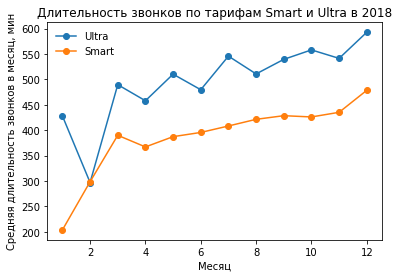

In [ ]:
# Сравним на графике данные по длительности звонков для пользователей обоих тарифов
fig, ax = plt.subplots()
ax.set(title='Длительность звонков по тарифам Smart и Ultra в 2018',
        xlabel='Месяц',
        ylabel='Средняя длительность звонков в месяц, мин')
ax.plot(ultra_pivot['month'], ultra_pivot['call_duration'], 'o-', label='Ultra')
ax.plot(smart_pivot['month'], smart_pivot['call_duration'], 'o-', label='Smart')
ax.legend(frameon=False)
plt.show()

<b>Наблюдение:</b>
В течение года заметен рост длительности разговоров по обоим тарифам. При этом длительность разговоров по тарифу "Ультра" значительно превышает показатели тарифа "Смарт".

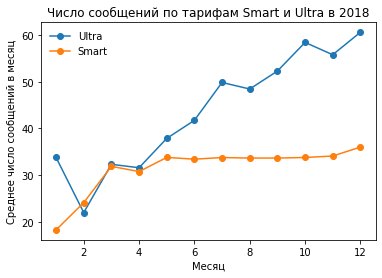

In [ ]:
# Сравним на графике данные по числу отправленных сообщений пользователями обоих тарифов
fig, ax = plt.subplots()
ax.set(title='Число сообщений по тарифам Smart и Ultra в 2018',
        xlabel='Месяц',
        ylabel='Среднее число сообщений в месяц')
ax.plot(ultra_pivot['month'], ultra_pivot['messages_number'], 'o-', label='Ultra')
ax.plot(smart_pivot['month'], smart_pivot['messages_number'], 'o-', label='Smart')
ax.legend(frameon=False)
plt.show()

<b>Наблюдение:</b>
В течение года заметен уверенный рост числа отправляемых сообщений по тарифу "Ультра". При этом тариф "Смарт" по данному показателю демонстрирует устойчивый выход на плато без динамики к росту - здесь что-то не так.

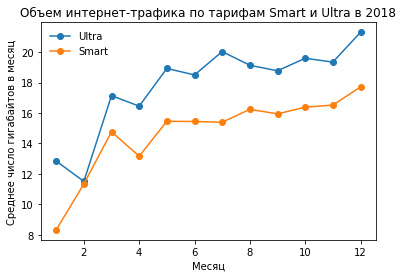

In [ ]:
# Сравним на графике данные по объему использованного трафика пользователями обоих тарифов
fig, ax = plt.subplots()
ax.set(title='Объем интернет-трафика по тарифам Smart и Ultra в 2018',
        xlabel='Месяц',
        ylabel='Среднее число гигабайтов в месяц')
ax.plot(ultra_pivot['month'], ultra_pivot['gb_used'], 'o-', label='Ultra')
ax.plot(smart_pivot['month'], smart_pivot['gb_used'], 'o-', label='Smart')
ax.legend(frameon=False)
plt.show()

<b>Наблюдение:</b>
В течение года заметен рост интернет-трафика по обоим тарифам. При этом рост потребления интернет-трафика по тарифу "Ультра" значительно превышает объем использованных гигабайтов по тарифу "Смарт".

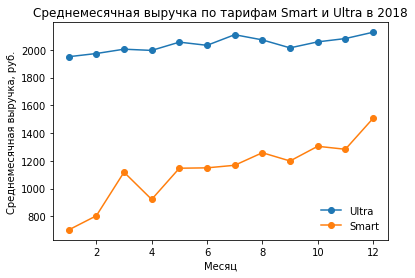

In [ ]:
# Сравним на графике данные по среднемесячной выручке от пользователей обоих тарифов
fig, ax = plt.subplots()
ax.set(title='Среднемесячная выручка по тарифам Smart и Ultra в 2018',
        xlabel='Месяц',
        ylabel='Среднемесячная выручка, руб.')
ax.plot(ultra_pivot['month'], ultra_pivot['monthly'], 'o-', label='Ultra')
ax.plot(smart_pivot['month'], smart_pivot['monthly'], 'o-', label='Smart')
ax.legend(frameon=False)
plt.show()

<b>Наблюдение:</b>
Выручка по тарифу "Ультра" значительно превышает вырочку по тарифу "Смарт": видимо, в силу изначально более высокой абонентской платы (1950 рублей в месяц против 550 рублей в месяц). При этом наблюдается отсутствие тенденции к росту выручки по тарифу "Ультра" в отличие от тарифа "Смарт", выручка по которому уверенно растет.

### 3.2 Статистический анализ поведения клиентов

Посчитаем среднее количество, дисперсию и стандартное отклонение.

#### 3.2.1 Для тарифа "Ультра"

In [ ]:
# Средние значения для тарифа "Ультра"
ultra_mean = ultra_total.mean()
ultra_mean

user_id            1263.094416
month                 8.250761
call_duration       526.623350
messages_number      49.363452
gb_used              19.030177
monthly            2060.529971
dtype: float64

In [ ]:
# Дисперсия для тарифа "Ультра"
ultra_var = np.var(ultra_total, ddof=1)
ultra_var

user_id             19795.057133
month                   8.247014
call_duration      100873.633397
messages_number      2285.266143
gb_used                97.213384
monthly            126953.285460
dtype: float64

In [ ]:
# Стандартное отклонение для тарифа "Ультра"
ultra_std_dev = np.std(ultra_total, ddof=1)
ultra_std_dev

user_id            140.694908
month                2.871762
call_duration      317.606098
messages_number     47.804457
gb_used              9.859685
monthly            356.305046
dtype: float64

Расчитаем промежуток, в котором находится 99% значений для тарифа "Ультра" по правилу трёх сигм.

In [ ]:
# Промежуток для 99% значений по длительности звонка для тарифа "Ультра"
ultra_duration_min = max(0, ultra_mean['call_duration'] - 3 * ultra_std_dev['call_duration'])
ultra_duration_max = ultra_mean['call_duration'] + 3 * ultra_std_dev['call_duration']
print('Длительность звонков пользователей тарифа "Ультра" в промежутке от {:.0f} до {:.0f} минут.'
      .format(ultra_duration_min, ultra_duration_max))

Длительность звонков пользователей тарифа "Ультра" в промежутке от 0 до 1479 минут.


In [ ]:
# Промежуток для 99% значений по отправленным сообщениям для тарифа "Ультра"
ultra_messages_min = max(0, (ultra_mean['messages_number'] - 3 * ultra_std_dev['messages_number']))
ultra_messages_max = ultra_mean['messages_number'] + 3 * ultra_std_dev['messages_number']
print('Количество отправленных сообщений пользователями тарифа "Ультра" в промежутке от {:.0f} до {:.0f} сообщений.'
      .format(ultra_messages_min, ultra_messages_max))

Количество отправленных сообщений пользователями тарифа "Ультра" в промежутке от 0 до 193 сообщений.


In [ ]:
# Промежуток для 99% значений по объёму использованного интернет-трафика для тарифа "Ультра"
ultra_gbused_min = max(0, ultra_mean['gb_used'] - 3 * ultra_std_dev['gb_used'])
ultra_gbused_max = ultra_mean['gb_used'] + 3 * ultra_std_dev['gb_used']
print('Объём интернет-трафика пользователей тарифа "Ультра" в промежутке от {:.0f} до {:.0f} гигабайт.'.format(ultra_gbused_min, ultra_gbused_max))

Объём интернет-трафика пользователей тарифа "Ультра" в промежутке от 0 до 49 гигабайт.


#### 3.2.2 Для тарифа "Смарт"

In [ ]:
# Средние значения для тарифа "Смарт"
smart_mean = smart_total.mean()
smart_mean

user_id            1246.506505
month                 8.346792
call_duration       417.934948
messages_number      33.384029
gb_used              15.848817
monthly            1233.349467
dtype: float64

In [ ]:
# Дисперсия для тарифа "Смарт"
smart_var = np.var(smart_total, ddof=1)
smart_var

user_id             21350.907161
month                   8.528245
call_duration       36219.315784
messages_number       796.812958
gb_used                32.945548
monthly            620452.607534
dtype: float64

In [ ]:
# Стандартное отклонение для тарифа "Смарт"
smart_std_dev = np.std(smart_total, ddof=1)
smart_std_dev

user_id            146.119496
month                2.920316
call_duration      190.313730
messages_number     28.227876
gb_used              5.739821
monthly            787.688141
dtype: float64

Расчитаем промежуток, в котором находится 99% значений для тарифа "Смарт" по правилу трёх сигм.

In [ ]:
# Промежуток для 99% значений по длительности звонка для тарифа "Смарт"
smart_duration_min = max(0, smart_mean['call_duration'] - 3 * smart_std_dev['call_duration'])
smart_duration_max = smart_mean['call_duration'] + 3 * smart_std_dev['call_duration']
print('Длительность звонков пользователей тарифа "Смарт" в промежутке от {:.0f} до {:.0f} минут.'
      .format(smart_duration_min, smart_duration_max))

Длительность звонков пользователей тарифа "Смарт" в промежутке от 0 до 989 минут.


In [ ]:
# Промежуток для 99% значений по отправленным сообщениям для тарифа "Смарт"
smart_messages_min = max(0, (smart_mean['messages_number'] - 3 * smart_std_dev['messages_number']))
smart_messages_max = smart_mean['messages_number'] + 3 * smart_std_dev['messages_number']
print('Количество отправленных сообщений пользователями тарифа "Смарт" в промежутке от {:.0f} до {:.0f} сообщений.'
      .format(smart_messages_min, smart_messages_max))

Количество отправленных сообщений пользователями тарифа "Смарт" в промежутке от 0 до 118 сообщений.


In [ ]:
# Промежуток для 99% значений по объёму использованного интернет-трафика для тарифа "Смарт"
smart_gbused_min = max(0, smart_mean['gb_used'] - 3 * smart_std_dev['gb_used'])
smart_gbused_max = smart_mean['gb_used'] + 3 * smart_std_dev['gb_used']
print('Объём интернет-трафика пользователей тарифа "Смарт" в промежутке от {:.0f} до {:.0f} гигабайт.'.format(smart_gbused_min, smart_gbused_max))

Объём интернет-трафика пользователей тарифа "Смарт" в промежутке от 0 до 33 гигабайт.


Для наглядности сравнения сведем собранные статистические данные в единую табличку.

In [ ]:
stat_values = pd.DataFrame({'Статистика': ['Средняя длительность звонков', 'Дисперсия по длительности звонков',
                                           'Стандартное отклонение по длительности звонков',
                                           'Средняя численность сообщений', 'Дисперсия по числу сообщений',
                                           'Стандартное отклонение по числу сообщений',
                                           'Средний интернет-трафик', 'Дисперсия по интернет-трафику',
                                           'Стандартное отклонение по интернет-трафику' ],

                            'Ультра': [ultra_mean['call_duration'],
                                      ultra_var['call_duration'], ultra_std_dev['call_duration'],
                                      ultra_mean['messages_number'],
                                      ultra_var['messages_number'], ultra_std_dev['messages_number'],
                                      ultra_mean['gb_used'], 
                                      ultra_var['gb_used'], ultra_std_dev['gb_used']],
                           
                            'Смарт': [smart_mean['call_duration'],
                                      smart_var['call_duration'], smart_std_dev['call_duration'],
                                      smart_mean['messages_number'], 
                                      smart_var['messages_number'], smart_std_dev['messages_number'],
                                      smart_mean['gb_used'], 
                                      smart_var['gb_used'], smart_std_dev['gb_used']]})
stat_values[['Ультра', 'Смарт']] = round(stat_values[['Ультра', 'Смарт']],0).astype('int')
stat_values = stat_values.set_index('Статистика')
stat_values

,Ультра,Смарт
Статистика,,
Средняя длительность звонков,527,418
Дисперсия по длительности звонков,100874,36219
Стандартное отклонение по длительности звонков,318,190
Средняя численность сообщений,49,33
Дисперсия по числу сообщений,2285,797
Стандартное отклонение по числу сообщений,48,28
Средний интернет-трафик,19,16
Дисперсия по интернет-трафику,97,33
Стандартное отклонение по интернет-трафику,10,6


### 3.3 Анализ гистограмм

Построим гистограммы и опишем распределения.

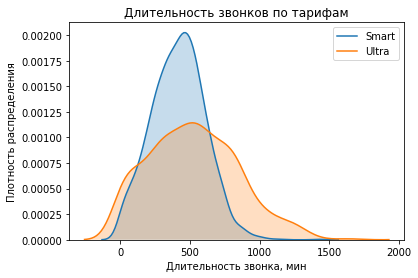

In [ ]:
# Длительность звонков по тарифам
plt.xlabel('Длительность звонка, мин')
plt.ylabel('Плотность распределения')
plt.title('Длительность звонков по тарифам')
sns.kdeplot(smart_total['call_duration'], shade=True, label="Smart")
sns.kdeplot(ultra_total['call_duration'], shade=True, label="Ultra")
plt.show()

Распределения выборок тарифов по длительности звонков близки к нормальным. При этом в тарифе "Ультра" генеральная выборка значений находится в более широком интервале со скосом вправо, то есть когда медианное значение меньше среднего. Это может свидетельствовать о том, что есть достаточно много пользователей тарифа "Ультра", которые используют тарифные минуты звонков свыше медианного показателя длительности.

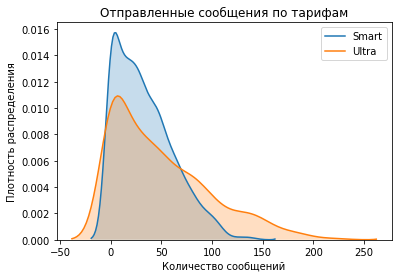

In [ ]:
# Отправленные сообщения по тарифам
plt.xlabel('Количество сообщений')
plt.ylabel('Плотность распределения')
plt.title('Отправленные сообщения по тарифам')
sns.kdeplot(smart_total['messages_number'], shade=True, label="Smart")
sns.kdeplot(ultra_total['messages_number'], shade=True, label="Ultra")
plt.show()

Распределения выборок тарифов по количеству отправленных сообщений близки к нормальным, при этом разброс значений больше в тарифе "Ультра". Оба тарифа представлены датасетами с положительной скошенностью (вправо), то есть медиана меньше среднего, и пользователи обоих тарифов используют опцию отсылки сообщений больше медианного значения: в тарифе "Ультра" чаще, чем в тарифе "Смарт".

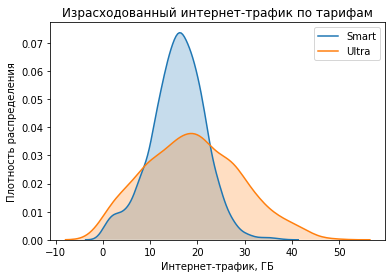

In [ ]:
# Израсходованный интернет-трафик по тарифам
plt.xlabel('Интернет-трафик, ГБ')
plt.ylabel('Плотность распределения')
plt.title('Израсходованный интернет-трафик по тарифам')
sns.kdeplot(smart_total['gb_used'], shade=True, label="Smart")
sns.kdeplot(ultra_total['gb_used'], shade=True, label="Ultra")
plt.show()

Распределения тарифов по интернет-трафику близки к нормальным и практически симметричны. Однако выборка тарифа "Смарт" по интернет-трафику скошена влево, то есть у пользователей этого тарифа наблюдается тенденция использовать гигабайты меньше медианного значения.

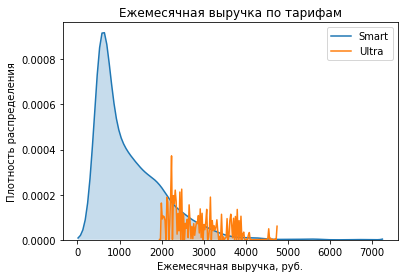

In [ ]:
# Ежемесячная выручка по тарифам
plt.xlabel('Ежемесячная выручка, руб.')
plt.ylabel('Плотность распределения')
plt.title('Ежемесячная выручка по тарифам')
sns.kdeplot(smart_total['monthly'], shade=True, label="Smart")
sns.kdeplot(ultra_total['monthly'], shade=True, label="Ultra")
plt.show()

Распределение тарифа "Смарт" по выручке близко к нормальному с положительной скошенностью, то есть для этого тарифа больше пользователей приносят выручку выше медианного значения.

Напротив, распределение тарифа "Ультра" по выручке совсем не выглядит нормальным, в нем много иррегулярностей и выбросов. Это может свидетельствовать о непостоянности и сложной непредсказуемости этого распределения. 

##  4. Проверка гипотез

### 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

В качестве генеральных совокупностей примем выборки тарифа "Ультра" (ultra_pivot) и тарифа "Смарт" (smart_pivot) по выручке. Начинаем формулировку гипотез, опираясь на типичные статистические гипотезы для средних значений.

<b>Нулевая гипотеза H0:</b> 
Средние двух генеральных совокупностей равны между собой.

<b>Альтернативная гипотеза H1:</b>
Средние двух генеральных совокупностей не равны между собой.

ultra_pivot и smart_pivot - это скорее выборки, а не генеральные совокупности. Тем не менее по центральной предельной теореме, выборочные средние распределены нормально вокруг истинного среднего генеральной совокупности. Для определения близости к среднему значению введём уровень значимости 5%.

Выборки являются независимыми. Дисперсия выборок оценивается по датасету каждой из выборок, а не по их объединению. Проверим гипотезы через распределение t-Стьюдента.

In [ ]:
sample_1 = ultra_total['monthly']
sample_2 = smart_total['monthly']

alpha = .05

results = st.ttest_ind(sample_1, sample_2, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 8.931402711368788e-296
Отвергаем нулевую гипотезу.


<b>ВЫВОД:</b>

Нулевая гипотеза отвергнута: p-value оказалось меньше уровня значимости 5%. Следовательно принимается альтернативная гипотеза: средние двух генеральных совокупностей не равны между собой.

То есть средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

### 4.2 Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Из из общей выборки пользователей total подготовим срез пользователей из Москвы moscow_users, а также срез пользователей из других регионов other_users.

In [ ]:
moscow_users = total.query('city == "Москва"')
other_users = total.query('city != "Москва"')

Сформируем гипотезы для выборок выручки пользователей из Москвы и пользователей из других регионов.

<b>Нулевая гипотеза H0:</b>
Средние двух генеральных совокупностей равны между собой.

<b>Альтернативная гипотеза H1:</b>
Средние двух генераальных совокупностей не равны между собой.

Для данных независимых выборок также действует центральная предельная теорема: выборочные средние распределены нормально вокруг истинного среднего генеральной совокупности. 

Опять-таки примем уровень значимости равный 5%.

In [ ]:
sample_1 = moscow_users['monthly']
sample_2 = other_users['monthly']

alpha = .05

results = st.ttest_ind(sample_1, sample_2, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.4549775646471024
Не получилось отвергнуть нулевую гипотезу.


<b>ВЫВОД:</b>

Нулевая гипотеза не может быть отвергнута (p-value больше уровня значимости), поэтому альтернативная гипотеза не принята.

То есть средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

<b>СОБРАННЫЕ НАБЛЮДЕНИЯ</b>

При сравнении тарифов было выявлено, что с января по декабрь 2018 года для обоих тарифов наблюдался рост и длительности звонков, и количества сообщений, и интернет-трафика. При этом длительность звонков и интернет-трафика потребителей тарифа "Ультра" превышала аналогичный показатель потребителя тарифа "Смарт". 

Распределения выборок тарифов по всем параметрам (длительности звонков, количеству сообщений, интернет-трафику) близки к нормальным. По объёму интернет-трафика распределения по обоим тарифам обладают отрицательной скошенностью, однако для тарифа "Ультра" данные расположены в более высоком регистре значений. Тариф "Ультра" по длительности звонков имеет более широкий интервал распределения, чем тариф "Смарт", а также скошенность вправо. А по количеству отправленных сообщений оба датасета скошены вправо. Это говорит нам о том, что в тарифе "Ультра" присутствуют пользователи, которые использует тарифные минуты звонков и отправляют сообщения свыше медианных значений, а также те, кто использует интернет-трафик ниже медианного значения. В тарифе "Смарт" есть пользователи с использованным интернет-трафиком ниже медианы, а также клиенты, отправляющие сообщения выше медианного значения.

Распределение выручки по тарифу "Смарт" близко к нормальному, но датасет скошен вправо, то есть существует большое число пользователей тарифа, которые приносят компании выручку выше медианного значения. Распределение выручки по тарифу "Ультра" выглядит непредсказуемо: пользователи приносят более высокую выручку компании, но у распределения очень много выбросов.

Были проведены t-тесты проверки двусторонних гипотез для двух независимых выборок. В результате этих испытаний было зафиксировано, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## 5. Общий вывод

Проведено исследование тарифов "Смарт" и "Ультра", которые предлагает оператор сотовой связи «Мегалайн». Анализ проведён на основе исходных данных о пользователях, звонках, сообщениях, интернет-сесссиях пользователей и тарифах. Проведена предобработка данных: изменение типа данных, выявление аномалий, расчёт дополнительных показателей. Явных ошибок/аномалий в данных не выявлено. Дополнительно собрана информация о длительности звонков, количестве отправленных сообщений, объёме использованного интернет-трафика.

Согласно предварительным наблюдениям пользователи, как правило, предпочитают использовать одну из опций тарифа: звонки, сообщения или интернет-трафик. Рассчитана ежемесячная выручка оператора в связи с использованием опций сверх абонентской платы.

Сравнение тарифов показывает, что на протяжении 2018 года для обоих тарифов наблюдается рост использования всех опций пакета: длительности звонков, количества отправленных сообщений и интернет-трафика. При этом длительность звонков и использованного интернет-трафика клиентов тарифа "Ультра" превышает аналогичный показатель тарифа "Смарт". 

Кроме того, проведены t-тесты с выбором подтвержденных гипотез, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.